# Pipeline for High-z Radio Galaxies 20: SHAP values for meta models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the meta-learners used for predictions.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

---

In [6]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_high_z_sources  = False
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [7]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Test_Train'  # Validation, Training, Test, Test_Train
if used_area == 'HETDEX':
    subset_str   = f'_{HETDEX_subset}'
if used_area != 'HETDEX':
    subset_str   = '_'

In [8]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [9]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [10]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [11]:
full_catalog_df['radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [12]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6729647 entries, 0 to 6729646
Data columns (total 91 columns):
 #   Column        Dtype  
---  ------        -----  
 0   RA_ICRS       float32
 1   DE_ICRS       float32
 2   Name          object 
 3   TYPE          object 
 4   Z             float32
 5   zsp           float32
 6   spCl          object 
 7   band_num      int64  
 8   radio_detect  int64  
 9   is_str        int64  
 10  is_AGN        int64  
 11  is_SDSS_gal   int64  
 12  is_gal        int64  
 13  W1mproPM      float32
 14  W2mproPM      float32
 15  gmag          float32
 16  rmag          float32
 17  imag          float32
 18  zmag          float32
 19  ymag          float32
 20  Jmag          float32
 21  Hmag          float32
 22  Kmag          float32
 23  W3mag         float32
 24  W4mag         float32
 25  g_r           float32
 26  g_i           float32
 27  g_z           float32
 28  g_y           float32
 29  g_J           float32
 30  g_H           floa

Create features with class and combined redshift.

In [13]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [14]:
if not use_high_z_sources:
    full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

#### Select relevant sources

In this case, high-redshift sources

In [15]:
if use_high_z_sources:
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [16]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                            random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
        train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                            random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])
        print('Shape of used data in HETDEX')
        print('(Confirmed galaxies and AGN)')
        print('-' * 50)
        print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
        print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
        print(f'Training data:                      {train_df.shape}')
        print(f'Testing data:                       {test_df.shape}')
        print(f'Unseen Data For Validation:         {validation_df.shape}')
        print('-' * 50)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 93)
Data for Modeling (Train and Test): (66727, 93)
Training data:                      (46708, 93)
Testing data:                       (20019, 93)
Unseen Data For Validation:         (16682, 93)
--------------------------------------------------

Using Test_Train data from HETDEX


In [17]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [18]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [19]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df

In [20]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (66727, 89)
--------------------------------------------------
Thus, it has 66,727 sources and 89 features.


### Load models

In [21]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [22]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [23]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [24]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [25]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [26]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [27]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [28]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on each meta learner.

In [29]:
run_shap_AGN_meta    = True
run_shap_radio_meta  = True
run_shap_z_meta      = True
run_shap_high_z_meta = False

In [30]:
selected_color = plt.get_cmap('cmr.guppy')  # cmr.pride, cet_CET_R3 cmr.wildfire cmr.guppy

#### SHAP - AGN/galaxy model

In [31]:
if run_shap_AGN_meta:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [32]:
if run_shap_AGN_meta:
    base_sample_size_AGN = 1000
    sample_size_AGN = np.nanmin([len(full_catalog_df), base_sample_size_AGN])
    print(f'Number of selected elements: {sample_size_AGN:,}')

Number of selected elements: 1,000


In [33]:
if run_shap_AGN_meta:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [34]:
if run_shap_AGN_meta:
    reduced_data_AGN    = full_catalog_df.sample(n=sample_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns

,class,pred_class
count,1000.000000,1000.000000
mean,0.374000,0.374000
std,0.484106,0.484106
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


Use FastTreeSHAP paccolumns

In [36]:
if run_shap_AGN_meta:
    explainer_AGN_meta = fasttreeshap.TreeExplainer(AGN_gal_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=reduced_data_AGN_df, feature_perturbation='interventional',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [37]:
if run_shap_AGN_meta:
    print('Working with meta-model')
    shap_values_AGN_meta = explainer_AGN_meta(reduced_data_AGN_df, check_additivity=False)

Working with meta-model


In [38]:
if run_shap_AGN_meta:
    explainer_AGN_meta.expected_value

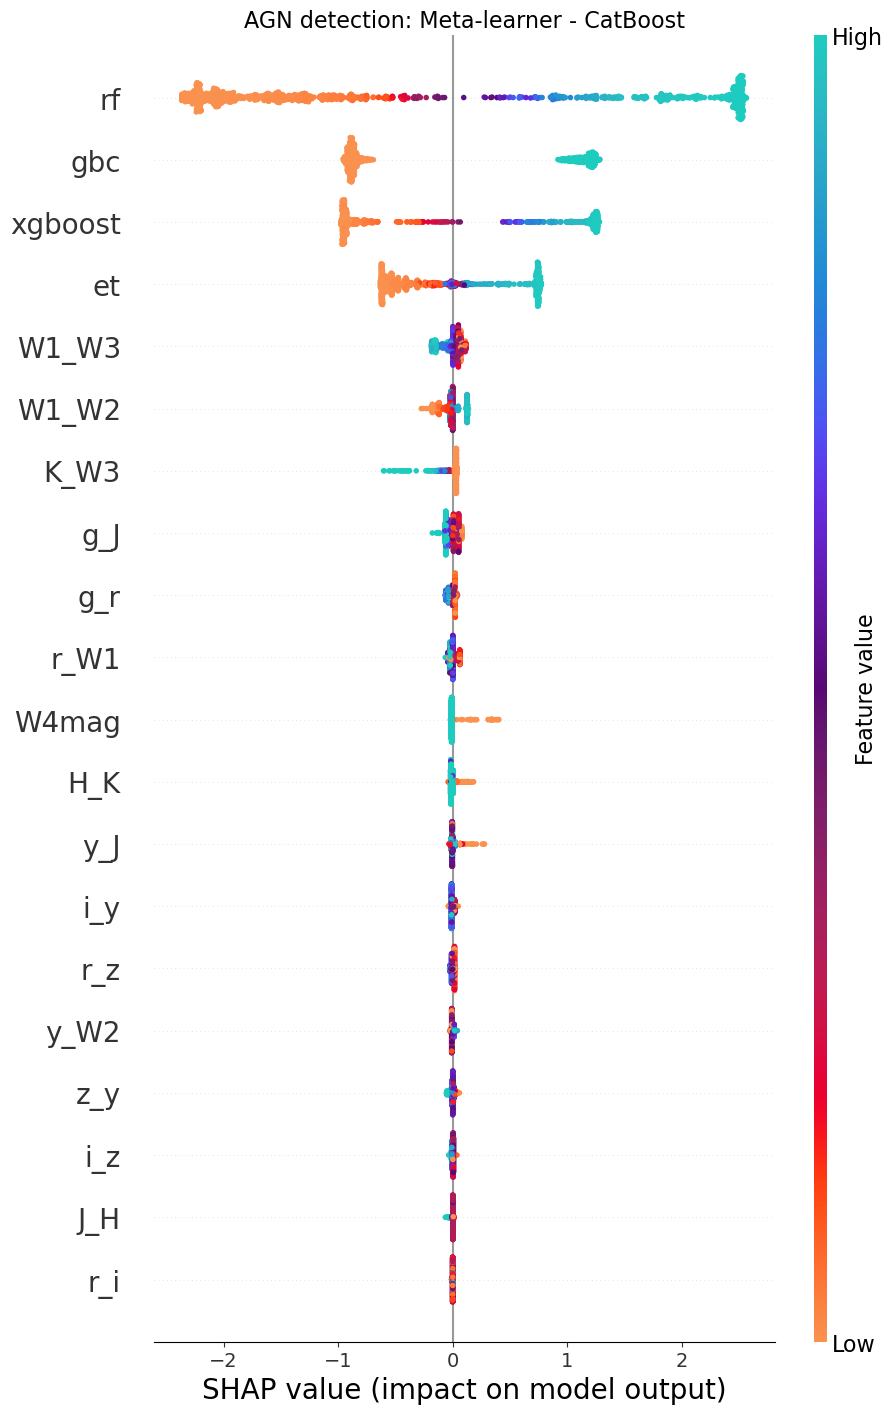

In [39]:
if run_shap_AGN_meta:
    gf.plot_shap_beeswarm('AGN/Galaxy class', model_name_AGN, shap_values_AGN_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

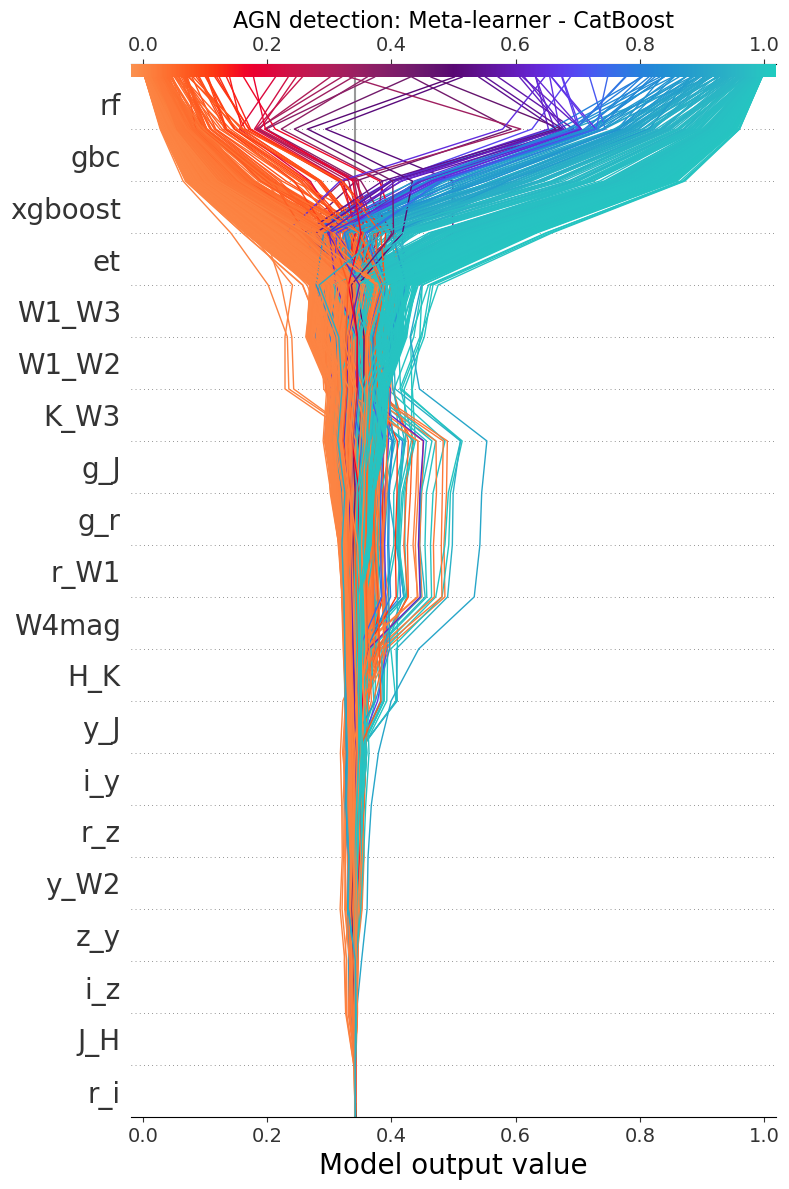

In [43]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.5 - 2.2e-5, 0.5 + 2.1e-5)
if run_shap_AGN_meta:
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('AGN/Galaxy class', model_name_AGN, shap_values_AGN_meta, explainer_AGN_meta,\
                              reduced_cols_AGN, ax1, 'logit', new_base_value=None, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_AGN_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

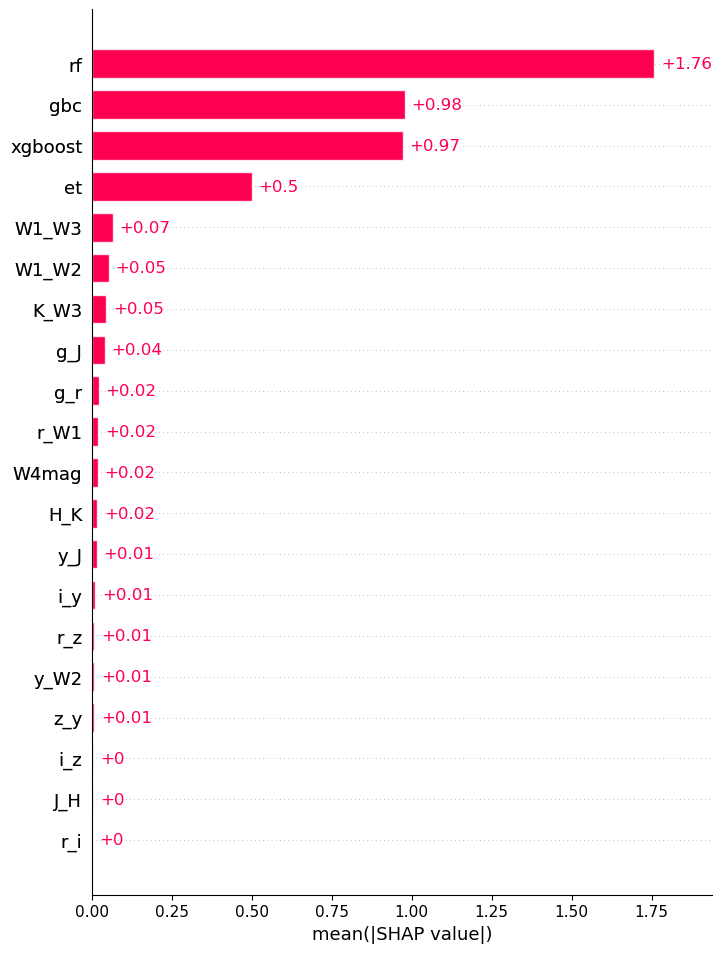

In [41]:
if run_shap_AGN_meta:
    shp_copy_AGN = shap.Explanation(values=shap_values_AGN_meta.values,\
                                    base_values=shap_values_AGN_meta.base_values,\
                                    data=shap_values_AGN_meta.data,\
                                    feature_names=shap_values_AGN_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_AGN, max_display=len(shp_copy_AGN.feature_names), show=False)
    plt.show()

In [42]:
if run_shap_AGN_meta:
    # The model's raw prediction for the first observation.
    print(AGN_gal_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_AGN_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_AGN_meta.expected_value + shap_values_AGN_meta.values[0].sum()).round(5))

0
-5.70171


---

#### SHAP - Radio detection model

In [43]:
if run_shap_radio_meta:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [44]:
if run_shap_radio_meta:
    sample_size_radio = 1000
    if not use_high_z_sources:
        if use_zeroth_model:
            filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
        elif not use_zeroth_model:
            filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
        filter_pred_AGN   = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    if use_high_z_sources:
        filter_pred_AGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio = np.nanmin([sample_size_radio, np.sum(filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 1,000


In [45]:
if run_shap_radio_meta:
    base_models_names_radio = gf.get_base_estimators_names(radio_det_clf)

In [46]:
if run_shap_radio_meta:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['radio_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_names_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns

,radio_detect,pred_radio
count,1000.00000,1000.000000
mean,0.28500,0.258000
std,0.45164,0.437753
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.00000,0.000000
75%,1.00000,1.000000
max,1.00000,1.000000


Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


Use FastTreeSHAP package

In [48]:
if run_shap_radio_meta:
    explainer_radio_meta = fasttreeshap.TreeExplainer(radio_det_clf.named_steps['trained_model'].final_estimator_,\
                                                    data=reduced_data_radio_df, feature_perturbation='interventional',\
                                                    model_output='raw', feature_dependence='independent',\
                                                    algorithm='auto', n_jobs=12)

In [49]:
if run_shap_radio_meta:
    print('Working with meta-model')
    shap_values_radio_meta = explainer_radio_meta(reduced_data_radio_df)

Working with meta-model


In [50]:
if run_shap_radio_meta:
    explainer_radio_meta.expected_value

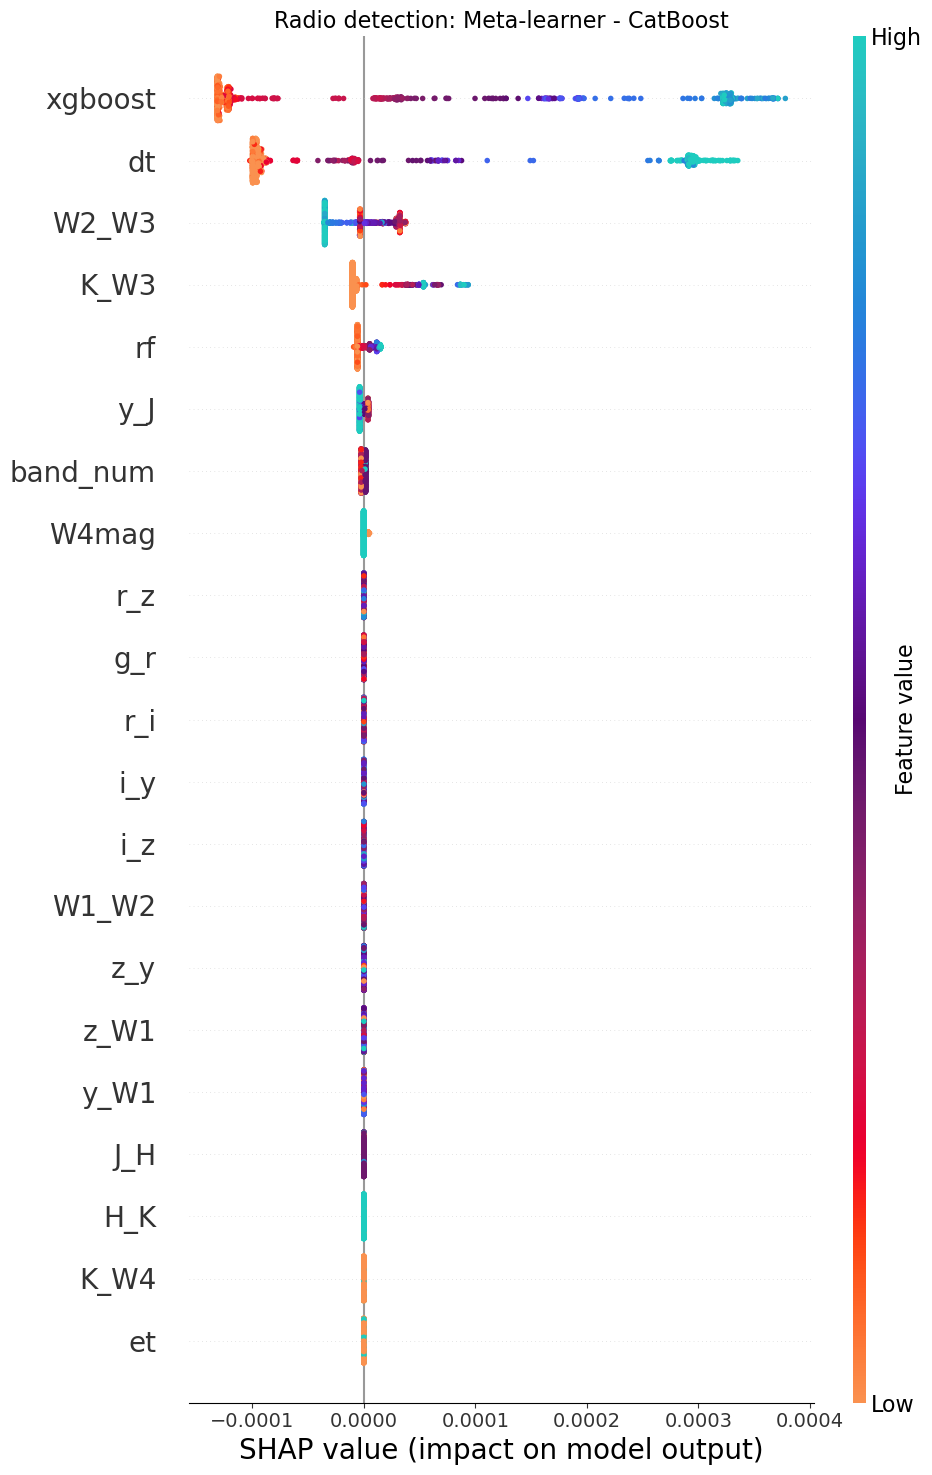

In [51]:
if run_shap_radio_meta:
    gf.plot_shap_beeswarm('Radio detection', model_name_radio, shap_values_radio_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

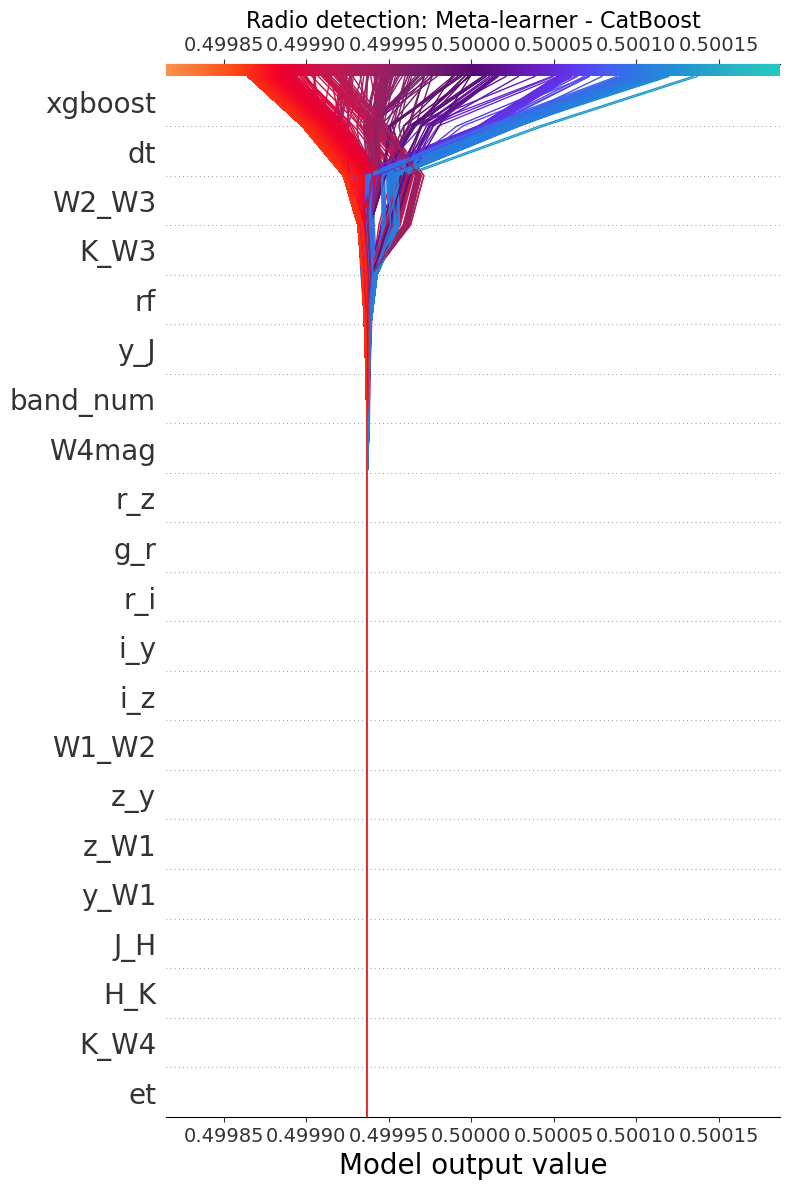

In [52]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_radio_meta:
    xlims_plt       = (full_catalog_df.loc[reduced_data_radio_df.index, 'Score_radio'].min() * 0.9999,\
                       full_catalog_df.loc[reduced_data_radio_df.index, 'Score_radio'].max() * 1.0001)
    size_side       = 8
    fig             = plt.figure(figsize=(size_side,size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Radio detection', model_name_radio, shap_values_radio_meta, explainer_radio_meta,\
                              reduced_cols_radio, ax1, 'logit', new_base_value=None, base_meta='Meta', xlim=xlims_plt)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_radio_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

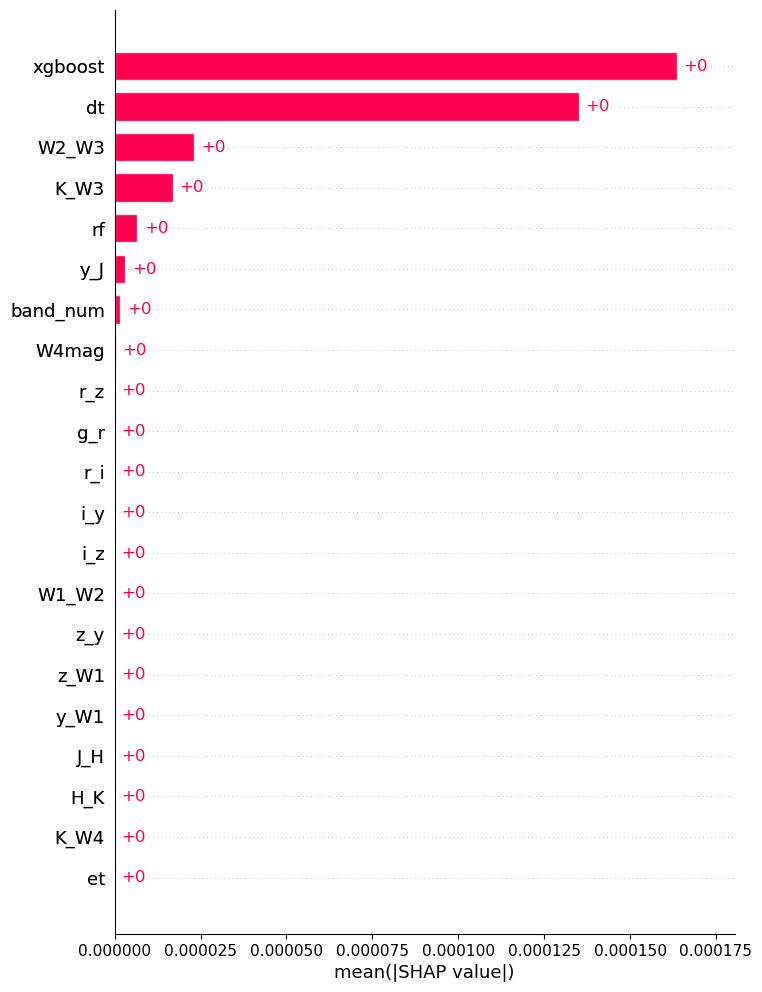

In [53]:
if run_shap_radio_meta:
    shp_copy_radio = shap.Explanation(values=shap_values_radio_meta.values,\
                                    base_values=shap_values_radio_meta.base_values,\
                                    data=shap_values_radio_meta.data,\
                                    feature_names=shap_values_radio_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_radio, max_display=len(shp_copy_radio.feature_names), show=False)
    plt.show()

In [54]:
if run_shap_radio_meta:
    # The model's raw prediction for the first observation.
    print(radio_det_clf.named_steps['trained_model'].final_estimator_.predict(reduced_data_radio_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_radio_meta.expected_value + shap_values_radio_meta.values[0].sum()).round(5))

1
0.00046


---

#### SHAP - First redshift prediction model

In [55]:
if run_shap_z_meta:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [56]:
if run_shap_z_meta:
    sample_size_z    = 1000
    if not use_high_z_sources:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    if use_high_z_sources:
        filter_pred_rAGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_z    = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 1,000


In [57]:
if run_shap_z_meta:
    base_models_names_z = gf.get_base_estimators_names(redshift_reg)

In [58]:
if run_shap_z_meta:
    reduced_data_z    = full_catalog_df.loc[filter_pred_rAGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_names_z)
    reduced_cols_z    = reduced_data_z_df.columns

,Z,pred_Z
count,1000.000000,1000.000000
mean,1.256272,1.244286
std,0.859894,0.834652
min,0.003000,0.024000
25%,0.520500,0.512000
50%,1.187500,1.178000
75%,1.856250,1.824750
max,4.540000,4.306000


Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


Use FastTreeSHAP package

In [60]:
if run_shap_z_meta:
    explainer_z_meta = fasttreeshap.TreeExplainer(redshift_reg.named_steps['trained_model'].final_estimator_,\
                                                  data=reduced_data_z_df, feature_perturbation='interventional',\
                                                  model_output='raw', feature_dependence='independent',\
                                                  algorithm='auto', n_jobs=12)

In [61]:
if run_shap_z_meta:
    print('Working with meta-model')
    shap_values_z_meta = explainer_z_meta(reduced_data_z_df)

 39%|========            | 391/1000 [00:11<00:17]       

Working with meta-model


 97%|=================== | 971/1000 [00:26<00:00]       

In [62]:
if run_shap_z_meta:
    explainer_z_meta.expected_value

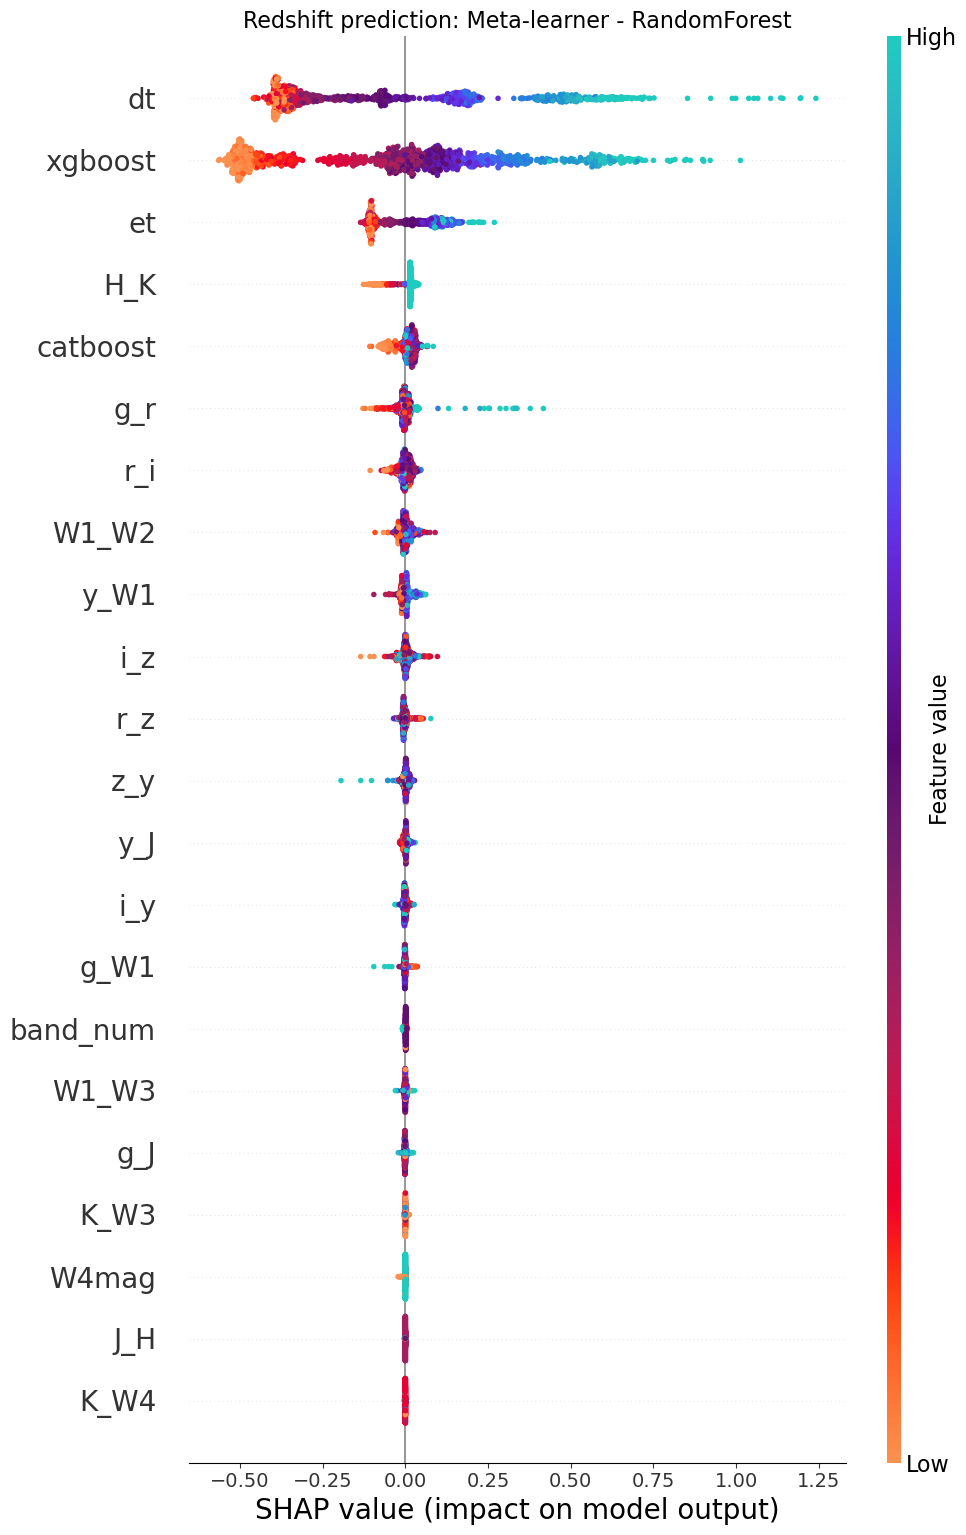

In [63]:
if run_shap_z_meta:
    gf.plot_shap_beeswarm('Redshift prediction', model_name_z, shap_values_z_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

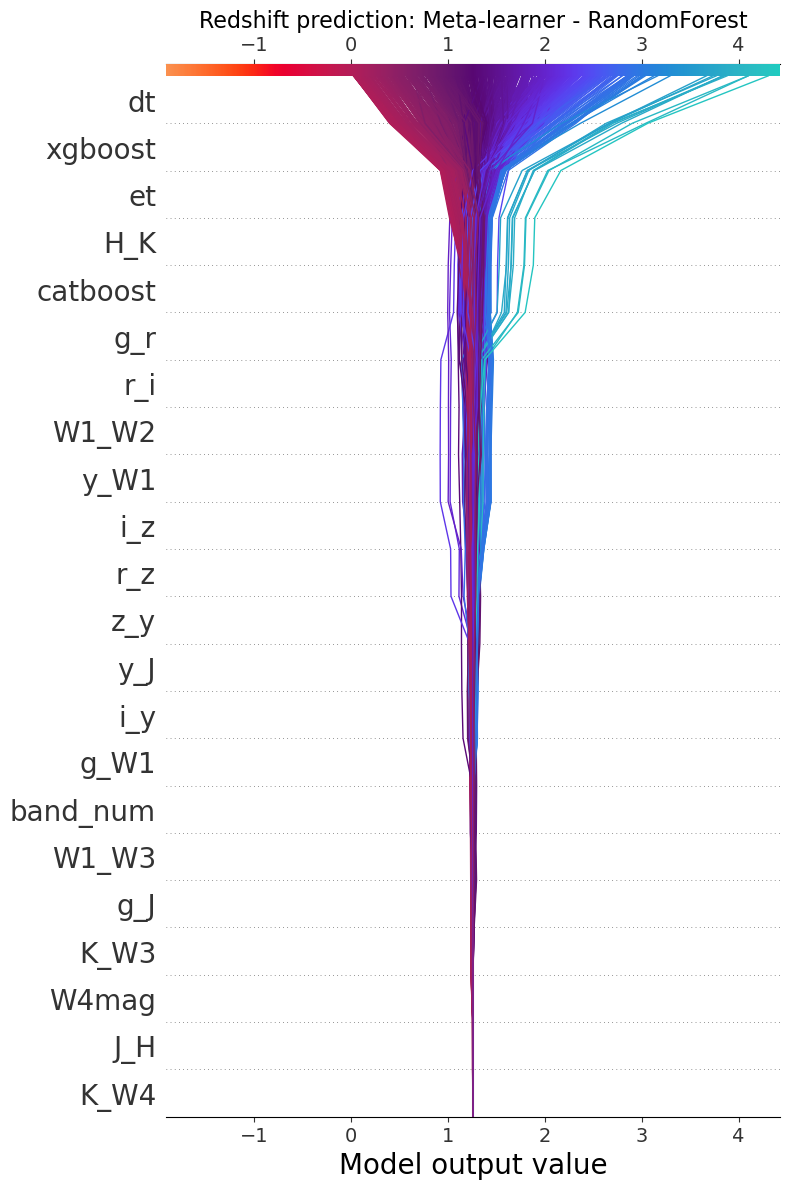

In [64]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_z_meta:
    xlims_plt_z     = (full_catalog_df.loc[reduced_data_z_df.index, 'Score_radio'].min(),\
                       full_catalog_df.loc[reduced_data_z_df.index, 'Score_radio'].max())
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('Redshift prediction', model_name_z, shap_values_z_meta, explainer_z_meta,\
                              reduced_cols_z, ax1, 'logit', new_base_value=None, base_meta='Meta', xlim=xlims_plt_z)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

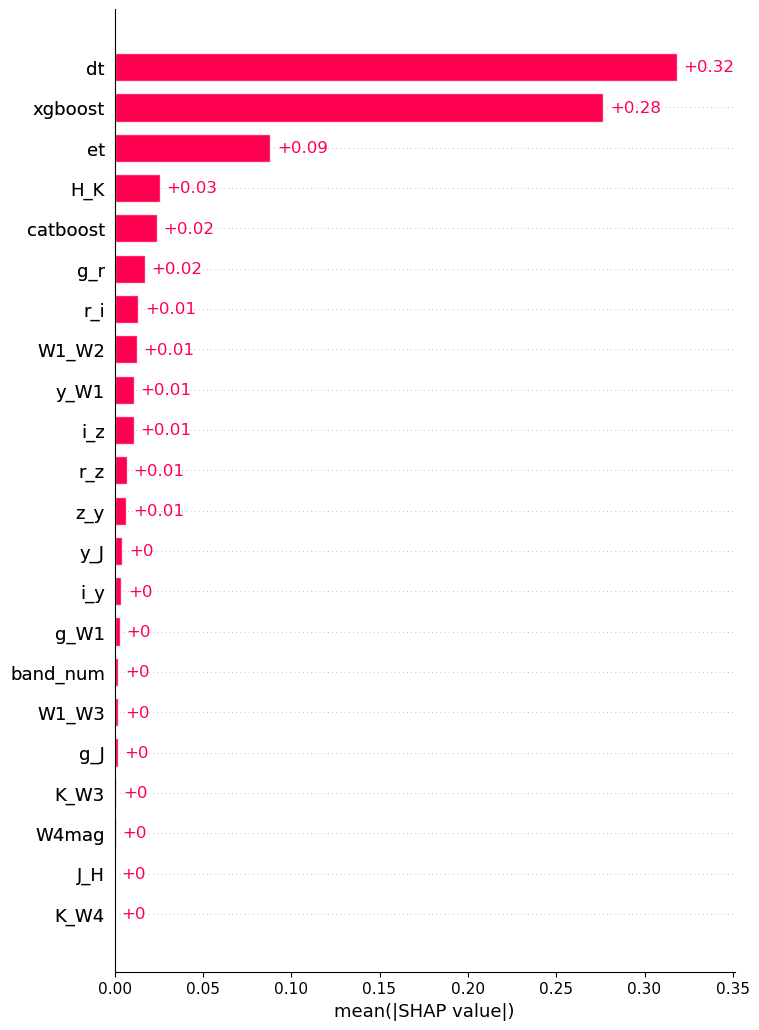

In [65]:
if run_shap_z_meta:
    shp_copy_z = shap.Explanation(values=shap_values_z_meta.values,\
                                    base_values=shap_values_z_meta.base_values,\
                                    data=shap_values_z_meta.data,\
                                    feature_names=shap_values_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_z, max_display=len(shp_copy_z.feature_names), show=False)
    plt.show()

In [66]:
if run_shap_z_meta:
    # The model's raw prediction for the first observation.
    print(redshift_reg.named_steps['trained_model'].final_estimator_.predict(reduced_data_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_z_meta.expected_value + shap_values_z_meta.values[0].sum()).round(5))

0.21047
0.21045


---

#### SHAP - Second redshift prediction model

In [67]:
if run_shap_high_z_meta & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [68]:
if run_shap_high_z_meta & use_second_z_model:
    sample_size_high_z      = 1000
    if not use_high_z_sources:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                  np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    if use_high_z_sources:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_high_z      = np.nanmin([sample_size_high_z, np.sum(filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

In [69]:
if run_shap_high_z_meta & use_second_z_model:
    base_models_names_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [70]:
if run_shap_high_z_meta & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_pred_rAGN_high_z].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    display(reduced_data_high_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_names_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns

Use FastTreeSHAP package

In [72]:
if run_shap_high_z_meta & use_second_z_model:
    explainer_high_z_meta = fasttreeshap.TreeExplainer(redshift_reg_2.named_steps['trained_model'].final_estimator_,\
                                                       feature_perturbation='tree_path_dependent',\
                                                       model_output='raw', feature_dependence='independent',\
                                                       algorithm='auto', n_jobs=12)

In [73]:
if run_shap_high_z_meta & use_second_z_model:
    print('Working with meta-model')
    shap_values_high_z_meta = explainer_high_z_meta(reduced_data_high_z_df)

In [74]:
if run_shap_high_z_meta & use_second_z_model:
    explainer_high_z_meta.expected_value

In [75]:
if run_shap_high_z_meta & use_second_z_model:
    gf.plot_shap_beeswarm('High redshift prediction', model_name_high_z, shap_values_high_z_meta, base_meta='Meta')
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_high_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [76]:
# (0.5 - 5e-6, 0.5 + 2e-5)
# (0.4998, 0.5002)
if run_shap_high_z_meta & use_second_z_model:
    xlims_plt_hz    = (full_catalog_df.loc[reduced_data_high_z_df.index, 'Score_radio'].min(),\
                       full_catalog_df.loc[reduced_data_high_z_df.index, 'Score_radio'].max())
    size_side       = 8
    fig             = plt.figure(figsize=(size_side, size_side * 3/2))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
    _ = gf.plot_shap_decision('High redshift prediction', model_name_high_z, shap_values_high_z_meta, explainer_high_z_meta,\
                              reduced_cols_high_z, ax1, 'logit', new_base_value=None, base_meta='Meta', xlim=xlims_plt_hz)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'SHAP_decision_high_z_meta_learner_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
    plt.show()

In [77]:
if run_shap_high_z_meta & use_second_z_model:
    shp_copy_high_z = shap.Explanation(values=shap_values_high_z_meta.values,\
                                    base_values=shap_values_high_z_meta.base_values,\
                                    data=shap_values_high_z_meta.data,\
                                    feature_names=shap_values_high_z_meta.feature_names)
    
    shap.plots.bar(shap_values=shp_copy_high_z, max_display=len(shp_copy_high_z.feature_names), show=False)
    plt.show()

In [78]:
if run_shap_high_z_meta & use_second_z_model:
    # The model's raw prediction for the first observation.
    print(redshift_reg_2.named_steps['trained_model'].final_estimator_.predict(reduced_data_high_z_df)[0].round(5))
    
    # The corresponding sum of the mean + shap values
    print((explainer_high_z_meta.expected_value + shap_values_high_z_meta.values[0].sum()).round(5))